## Projeto Analysis of Diabetes Risk Factor

### Machine Learning.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

### Carregando o Dataset pré-processado

In [2]:
df_diabetes_indcators = pd.read_csv("..\\datalake\\processing\\diabetes_indcators.csv", index_col=0)

In [3]:
df_diabetes_indcators.head()

,high_blood_preassure,high_cholesterol,body_mass_index,age,physical_activity_in_past_30_days,physical_illness_injury_days,education,income,serious_difficulty_walking,heart_diseaseor_attack,days_of_poor_mental_health,general_health_scale,avc,cholesterol_check,smoker,at_least_one_veggies_a_day,high_consumption_of_alcohol,diabetes
0,1,1,40.0,9,0,15,4,3,1,0,18,5,0,1,1,1,0,0
1,0,0,25.0,7,1,0,6,1,0,0,0,3,0,0,1,0,0,0
2,1,1,28.0,9,0,30,4,8,1,0,30,5,0,1,0,0,0,0
3,1,0,27.0,11,1,0,3,6,0,0,0,2,0,1,0,1,0,0
4,1,1,24.0,11,1,0,5,4,0,0,3,2,0,1,0,1,0,0


### Transformação de Features

In [4]:
def map_imc_ranges(x):
    if x <= 18.49:
        return 'under_weight'
    elif x >= 18.50 and x <=24.99:
        return 'normal_weight'
    elif x >= 25 and x <=29.99:
        return 'overweight'
    elif x >= 30 and x <=34.99:
        return 'obesity_I'
    elif x >= 35 and x <=39.99:
        return 'obesity_II'
    elif x >= 40:
        return 'obesity_III'
    else:
        return 'NaN'

In [5]:
df_diabetes_indcators['body_mass_index'] = df_diabetes_indcators['body_mass_index'].map(lambda x:map_imc_ranges(x))

In [6]:
def map_age_ranges(x):
    switcher = {
        1: "below_30",
        2: "below_30",
        3: "30_39",
        4: "30_39",
        5: "40_49",
        6: "40_49",
        7: "50_59",
        8: "50_59",
        9: "60_69",
        10: "60_69",
        11: "above_70",
        12: "above_70",
        13: "above_70"
    }
    return switcher.get(x, 0)

In [7]:
df_diabetes_indcators['age'] = df_diabetes_indcators['age'].map(lambda x:map_age_ranges(x))

In [8]:
def map_physical_mental_health_days(x):
    if x == 0:
        return 'zero'
    elif x >= 1 and x <=7:
        return '1_7'
    elif x >= 8 and x <=13:
        return '8_13'
    elif x >= 14 and x <=21:
        return '14_21'
    elif x >= 22 and x <=30:
        return '22_30'
    else:
        return 'NaN'

In [9]:
df_diabetes_indcators['physical_illness_injury_days'] = df_diabetes_indcators['physical_illness_injury_days']\
    .map(lambda x:map_physical_mental_health_days(x))

In [10]:
def map_income_scale(x):
    switcher = {
        1: '1',
        2: '1',
        3: '2',
        4: '2',
        5: '3',
        6: '3',
        7: '4',
        8: '4'
    }
    return switcher.get(x, 0)

In [11]:
df_diabetes_indcators['income'] = df_diabetes_indcators['income'].map(lambda x:map_income_scale(x))

In [12]:
def map_health_scale(x):
    switcher = {
        1: '1',
        2: '1',
        3: '2',
        4: '3',
        5: '3'
    }
    return switcher.get(x, 0)

In [13]:
df_diabetes_indcators['general_health_scale'] = df_diabetes_indcators['general_health_scale']\
    .map(lambda x:map_health_scale(x))

In [14]:
df_diabetes_indcators.head()

,high_blood_preassure,high_cholesterol,body_mass_index,age,physical_activity_in_past_30_days,physical_illness_injury_days,education,income,serious_difficulty_walking,heart_diseaseor_attack,days_of_poor_mental_health,general_health_scale,avc,cholesterol_check,smoker,at_least_one_veggies_a_day,high_consumption_of_alcohol,diabetes
0,1,1,obesity_III,60_69,0,14_21,4,2,1,0,18,3,0,1,1,1,0,0
1,0,0,overweight,50_59,1,zero,6,1,0,0,0,2,0,0,1,0,0,0
2,1,1,overweight,60_69,0,22_30,4,4,1,0,30,3,0,1,0,0,0,0
3,1,0,overweight,above_70,1,zero,3,3,0,0,0,1,0,1,0,1,0,0
4,1,1,normal_weight,above_70,1,zero,5,2,0,0,3,1,0,1,0,1,0,0


### Dummy das variáveis categóricas

In [15]:
df_diabetes_indcators = df_diabetes_indcators.drop(['education', 'days_of_poor_mental_health', 'cholesterol_check',
                                                    'at_least_one_veggies_a_day'], axis = 1)

In [16]:
variables_cat = ['income', 'age', 'general_health_scale',
                 'physical_illness_injury_days','body_mass_index']
df_diabetes_dummy = pd.get_dummies(df_diabetes_indcators, columns = variables_cat)

In [17]:
df_diabetes_dummy.head()

,high_blood_preassure,high_cholesterol,physical_activity_in_past_30_days,serious_difficulty_walking,heart_diseaseor_attack,avc,smoker,high_consumption_of_alcohol,diabetes,income_1,...,physical_illness_injury_days_1_7,physical_illness_injury_days_22_30,physical_illness_injury_days_8_13,physical_illness_injury_days_zero,body_mass_index_normal_weight,body_mass_index_obesity_I,body_mass_index_obesity_II,body_mass_index_obesity_III,body_mass_index_overweight,body_mass_index_under_weight
0,1,1,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,1,0,0,0,1,0,0,1,...,0,0,0,1,0,0,0,0,1,0
2,1,1,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
3,1,0,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,1,1,1,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0


In [18]:
from sklearn.ensemble import RandomForestClassifier 

In [19]:
X = df_diabetes_dummy.drop(['diabetes'], axis = 1)
y = df_diabetes_dummy['diabetes']

base_model = RandomForestClassifier(max_depth = 9) 
base_model.fit(X, y) 

RandomForestClassifier(max_depth=9)

In [20]:
variables = pd.DataFrame()
variables['variable'] = X.columns
variables['importance'] = base_model.feature_importances_

In [21]:
variables.sort_values(by = 'importance', ascending = False)

,variable,importance
0,high_blood_preassure,0.203978
18,general_health_scale_1,0.144837
20,general_health_scale_3,0.112046
1,high_cholesterol,0.107754
3,serious_difficulty_walking,0.083709
26,body_mass_index_normal_weight,0.054704
4,heart_diseaseor_attack,0.048489
29,body_mass_index_obesity_III,0.037179
19,general_health_scale_2,0.029355
28,body_mass_index_obesity_II,0.021001


<AxesSubplot:ylabel='variable'>

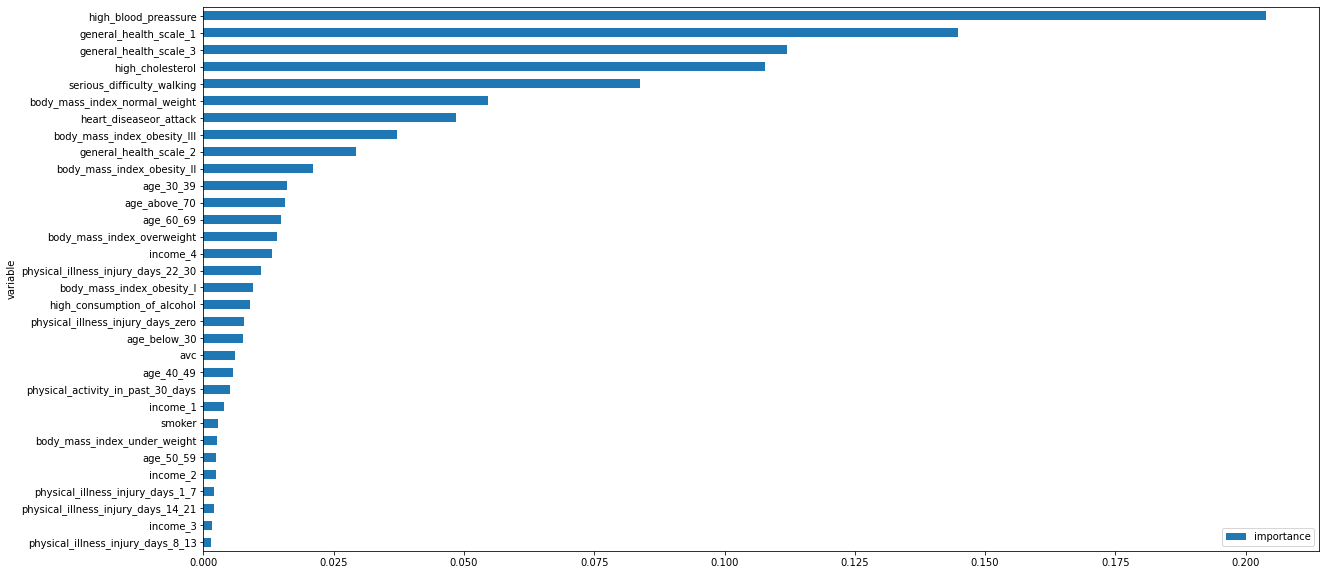

In [22]:
variables.sort_values(by = 'importance', ascending = True, inplace = True)
variables.set_index('variable', inplace = True)
variables.plot(kind='barh', figsize=(20, 10))

#### Filtrando apenas os atributos relevantes.

In [23]:
X = df_diabetes_dummy.drop(["diabetes"], axis=1)
y = df_diabetes_dummy['diabetes']

#### Realizando balanceamento de classes.

In [24]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

In [25]:
nm = NearMiss(sampling_strategy=0.40)

In [26]:
x_nm, y_nm = nm.fit_resample(X, y)

In [27]:
smote = SMOTE(sampling_strategy=0.60, random_state=33)

In [28]:
x_smote, y_smote = smote.fit_resample(x_nm, y_nm)

#### Separando os conjuntos de dados.

In [29]:
y_smote.value_counts()

0    87742
1    52645
Name: diabetes, dtype: int64

In [29]:
scaler = MinMaxScaler()

In [125]:
X = scaler.fit_transform(x_smote)

In [126]:
X_train, X_test, y_train, y_test = train_test_split(
        X
       ,y_smote
       ,test_size = 0.2
       ,random_state = 123
)

#### Função do modelo de base.

In [127]:
def base_rate_model(X) :
    return np.zeros(X.shape[0])

#### Importando métodos de métrica de avaliação.

In [128]:
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report

In [129]:
def roc_classification_report_results(model,y_test,y_predict):
    roc_ = roc_auc_score(y_test, y_predict)
    classfication_report = classification_report(y_test, y_predict)
    
    print ("\n{} AUC = {}\n".format(model, roc_))
    print(classfication_report)

#### Análise do modelo de baseline

In [130]:
y_predict = base_rate_model(X_test)

In [131]:
roc_classification_report_results("Base Model", y_test, y_predict)


Base Model AUC = 0.5

              precision    recall  f1-score   support

           0       0.62      1.00      0.77     17507
           1       0.00      0.00      0.00     10571

    accuracy                           0.62     28078
   macro avg       0.31      0.50      0.38     28078
weighted avg       0.39      0.62      0.48     28078



C:\Users\Joaquim Aniceto\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Modelo de Árvore de Decisão

#### Instânciando o algoritmo.

In [132]:
from sklearn.tree import DecisionTreeClassifier
decision_tree = DecisionTreeClassifier()

#### Realizando o treinamento.

In [133]:
decision_tree.fit(X_train,y_train)

DecisionTreeClassifier()

#### Calculando as predições.

In [134]:
y_predict = decision_tree.predict(X_test)

#### Avaliando o resultado.

In [135]:
roc_classification_report_results("Decision Tree", y_test, y_predict)


Decision Tree AUC = 0.6933812498758216

              precision    recall  f1-score   support

           0       0.75      0.89      0.81     17507
           1       0.73      0.50      0.59     10571

    accuracy                           0.74     28078
   macro avg       0.74      0.69      0.70     28078
weighted avg       0.74      0.74      0.73     28078



### Modelo de Arvore Aleatória (Random Forest)

#### Instânciando o algoritmo.

In [136]:
from sklearn.ensemble import RandomForestClassifier

In [137]:
random_forest = RandomForestClassifier()

#### Realizando o treinamento.

In [138]:
random_forest.fit(X_train,y_train)

RandomForestClassifier()

#### Calculando as predições.

In [139]:
y_predict = random_forest.predict(X_test)

#### Avaliando o resultado.

In [140]:
roc_classification_report_results("Random Forest", y_test, y_predict)


Random Forest AUC = 0.7212843419195425

              precision    recall  f1-score   support

           0       0.77      0.87      0.82     17507
           1       0.72      0.57      0.64     10571

    accuracy                           0.76     28078
   macro avg       0.75      0.72      0.73     28078
weighted avg       0.75      0.76      0.75     28078



### Pycaret

In [ ]:
pip install pycaret

#### Importando os métodos.

In [31]:
from pycaret.classification import *

#### Definindo o Setup.

In [35]:
x_smote['diabetes']=y_smote
defined_setup = setup(x_smote
          ,target = "diabetes"
          ,normalize = True
          ,categorical_features=list(X.columns)
          ,normalize_method = "minmax"
          ,data_split_stratify = True
          ,fix_imbalance = True,
          fix_imbalance_method = SMOTE(sampling_strategy=0.8)
         )


,Description,Value
0,session_id,1672
1,Target,diabetes
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(140387, 33)"
5,Missing Values,False
6,Numeric Features,0
7,Categorical Features,32
8,Ordinal Features,False
9,High Cardinality Features,False


#### Comparando diferentes modelos.

In [36]:
best_model = compare_models(fold = 5,sort = 'AUC', include = ['lightgbm', 'xgboost'], probability_threshold = 0.45)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8021,0.8782,0.7549,0.7277,0.7410,0.5810,0.5813,15.9280
lightgbm,Light Gradient Boosting Machine,0.8004,0.8764,0.7589,0.7228,0.7404,0.5785,0.5790,13.2260


#### Criando o modelo.

In [37]:
xgboost = create_model('xgboost', fold = 5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8089,0.8813,0.7196,0.7585,0.7385,0.5881,0.5886
1,0.8070,0.8781,0.7195,0.7544,0.7366,0.5844,0.5848
2,0.8098,0.8780,0.7220,0.7591,0.7401,0.5903,0.5907
3,0.8082,0.8800,0.7235,0.7548,0.7388,0.5874,0.5877
4,0.8039,0.8740,0.7149,0.7504,0.7322,0.5777,0.5781
Mean,0.8076,0.8783,0.7199,0.7554,0.7372,0.5856,0.5860
SD,0.0020,0.0025,0.0029,0.0031,0.0027,0.0044,0.0044


#### Realizando o tunning do modelo.

In [38]:
tuned_xgboost = tune_model(xgboost,
                           fold = 5,
                           custom_grid = {
                              "learning_rate":[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
                             ,"n_estimators":[x for x in range(100, 1100, 100)]
                             ,"max_features":['sqrt', 'log2', None]
                             ,"max_depth":[2, 4, 8, 16]
                            },
                           optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8086,0.8803,0.7087,0.7640,0.7353,0.5858,0.5868
1,0.8060,0.8777,0.7156,0.7544,0.7345,0.5818,0.5823
2,0.8093,0.8784,0.7092,0.7651,0.7361,0.5871,0.5882
3,0.8077,0.8790,0.7130,0.7594,0.7355,0.5846,0.5853
4,0.8028,0.8736,0.7066,0.7525,0.7289,0.5742,0.5749
Mean,0.8069,0.8778,0.7106,0.7591,0.7340,0.5827,0.5835
SD,0.0023,0.0023,0.0032,0.0050,0.0026,0.0046,0.0047


#### Finalizando o modelo.

In [39]:
final_model = finalize_model(tuned_xgboost)

In [40]:
save_model(final_model,'..\\datalake\\curated\\model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['high_blood_preassure',
                                                             'high_cholesterol',
                                                             'physical_activity_in_past_30_days',
                                                             'serious_difficulty_walking',
                                                             'heart_diseaseor_attack',
                                                             'avc', 'smoker',
                                                             'high_consumption_of_alcohol',
                                                             'income_1',
                                                             'income_2',
                                                             'income_3',
                                                             'income_4',
                                             

#### Transferindo os arquivos para o Data Lake.

In [41]:
x_smote.to_csv("..\\datalake\\curated\\dataset.csv", index=False)